# BlackJack - First-visit Monte Carlo Prediction of state-value-function $v_\pi$
Estimating the state-value-function for a deterministic player-policy and fixed deterministic dealer-policy<br><br>
Returns: 1 for win, 0 for draw, -1 for loosing an episode<br>
Undiscounted return ($\gamma = 1$)

In [1]:
import numpy as np

In [4]:
class Hand:
    """
    
    """
    def __init__(self, name):
        self.name = name
        self.cards = []
        self.usableAce=False
    
    def hit(self):
        cardValue = np.random.randint(1, 11)
        if(cardValue == 1 and not self.usableAce and self.sum()+11 <= 21):
            self.usableAce = True
        self.cards.append(cardValue)
        if self.sum() > 21 and self.usableAce:
            self.usableAce = False
            
    def sum(self):
        return np.sum(self.cards)+(10 if self.usableAce else 0)
    
    def eyes(self):
        return np.sum(self.cards)
    
    def __str__(self):
        return self.name+(" cards:")+str(self.cards)+" sum:"+str(self.sum())
    
    def __repr__(self):
        return self.__str__()

def dealer_policy(hand):
    return "hit" if hand.sum() < 17 else "stick"

def player_policy(hand):
    return "hit" if hand.sum() < 20 else "stick"

def runEpisode(dealer_policy, player_policy):
    states = []
    
    dealer = Hand("dealer")
    dealer.hit()
    dealersEyes = dealer.eyes()-1
    dealer.hit()
    player = Hand("player")
    player.hit()
    player.hit()
    states.append((dealersEyes, np.max([player.sum()-12,0]), int(player.usableAce)))
    while(player_policy(player) == "hit"):
        player.hit()
        if(player.sum() > 21):
            return set(states), -1
        states.append((dealersEyes, np.max([player.sum()-12,0]), int(player.usableAce)))
    while(dealer_policy(dealer) == "hit"):
        dealer.hit()
        if(dealer.sum() > 21):
            return set(states), 1
    reward = -1
    if player.sum() == dealer.sum(): 
        reward = 0
    if player.sum() < 22 and player.sum() > dealer.sum(): 
        reward =  1
    return set(states), reward

In [5]:
# containers to store (tabular) value-function and expected return - we will represent states as tuples and use them as dict-indices
# missing indices are automatically (lazy) initialized with 0
v = dict() # iteratively updated value per state
returns = dict() # incremental calc of average of undiscounted return per state - entries are tuples: (nReturns, avg)

def addReturnToIncrAvg(r, s, vDict):
    if(s in vDict):
        nReturns = vDict[s][0]
        avg = vDict[s][1]
        vDict[s] = (nReturns+1, (avg*nReturns)/(nReturns+1) + r/(nReturns+1))
    else:
        vDict[s] = (1, r)
    return vDict

def updateStateValue(val, s, v):
    v[s] = val
    return v

# run
n_episodes = 50000
for _ in range(n_episodes):
    states, reward = runEpisode(dealer_policy, player_policy)
    for s in states:
        returns = addReturnToIncrAvg(reward, s, returns)
    for s in states:
        v = updateStateValue(returns[s][1], s, v)

## Plot state-value-function $v_\pi$

In [6]:
from mpl_toolkits.mplot3d.axes3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [7]:
x = np.linspace(0, 9, 10, dtype=np.int)
y = np.linspace(0, 9, 10, dtype=np.int)
X,Y = np.meshgrid(x, y)
Z0 = np.empty((10,10))
Z1 = np.empty((10,10))
for i in X.flatten():
    for j in Y.flatten():
        val0 = val1 = 0
        if (i,j,0) in v: val0 = v[(i,j,0)]
        if (i,j,1) in v: val1 = v[(i,j,1)]
        Z0[j,i] = val0
        Z1[j,i] = val1

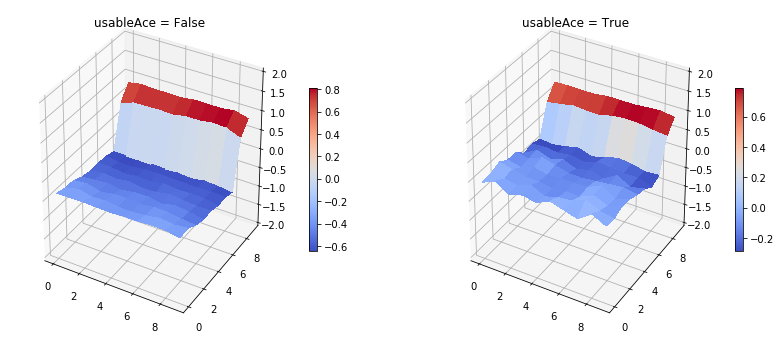

In [9]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title('usableAce = False')
p = ax.plot_surface(X, Y, Z0, cmap=cm.coolwarm, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)
ax.set_zlim(-2,2)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('usableAce = True')
p = ax.plot_surface(X, Y, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
cb = fig.colorbar(p, shrink=0.5)
ax.set_zlim(-2,2)
None